# 6. Custom backend definition

## LOCC backends
One example of these recent improvements in Qiskit is supporting LOCC backends, or in other words multi-chip backends that don't have quantum connectivity between the chips.

In [1]:
import numpy as np
import rustworkx as rx

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, IfElseOp, Reset


class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        """Instantiate a new fake multi chip backend.

        Args:
            distance (int): The heavy hex code distance to use for each chips'
                coupling map. This number **must** be odd. The distance relates
                to the number of qubits by:
                :math:`n = \\frac{5d^2 - 2d - 1}{2}` where :math:`n` is the
                number of qubits and :math:`d` is the ``distance``
            number_of_chips (int): The number of chips to have in the multichip backend
                each chip will be a heavy hex graph of ``distance`` code distance.
        """
        super().__init__(name='Fake LOCC backend')
        graph = rx.generators.directed_heavy_hex_graph(distance, bidirectional=False)
        num_qubits = len(graph) * number_of_chips
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake multi-chip backend", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        # Add chip local 2q gate which is cz
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

In [2]:
import os
import tempfile

from PIL import Image

from qiskit.visualization import plot_gate_map

# Generate a backend with 3x 883 qubit heavy-hex chips (2649 qubits total):
backend = FakeLOCCBackend(19, 3)

In [3]:
from qiskit import QuantumCircuit, transpile

# Build 3x 500 qubit ghz states
ghz = QuantumCircuit(1500)
ghz.h(0)
ghz.cx(0, range(1, 500))
ghz.cx(500, range(501, 1000))
ghz.cx(1000, range(1001, 1500))
ghz.measure_all()

/Users/mirko/opt/miniconda3/envs/qeet_enablement/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (156181364 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


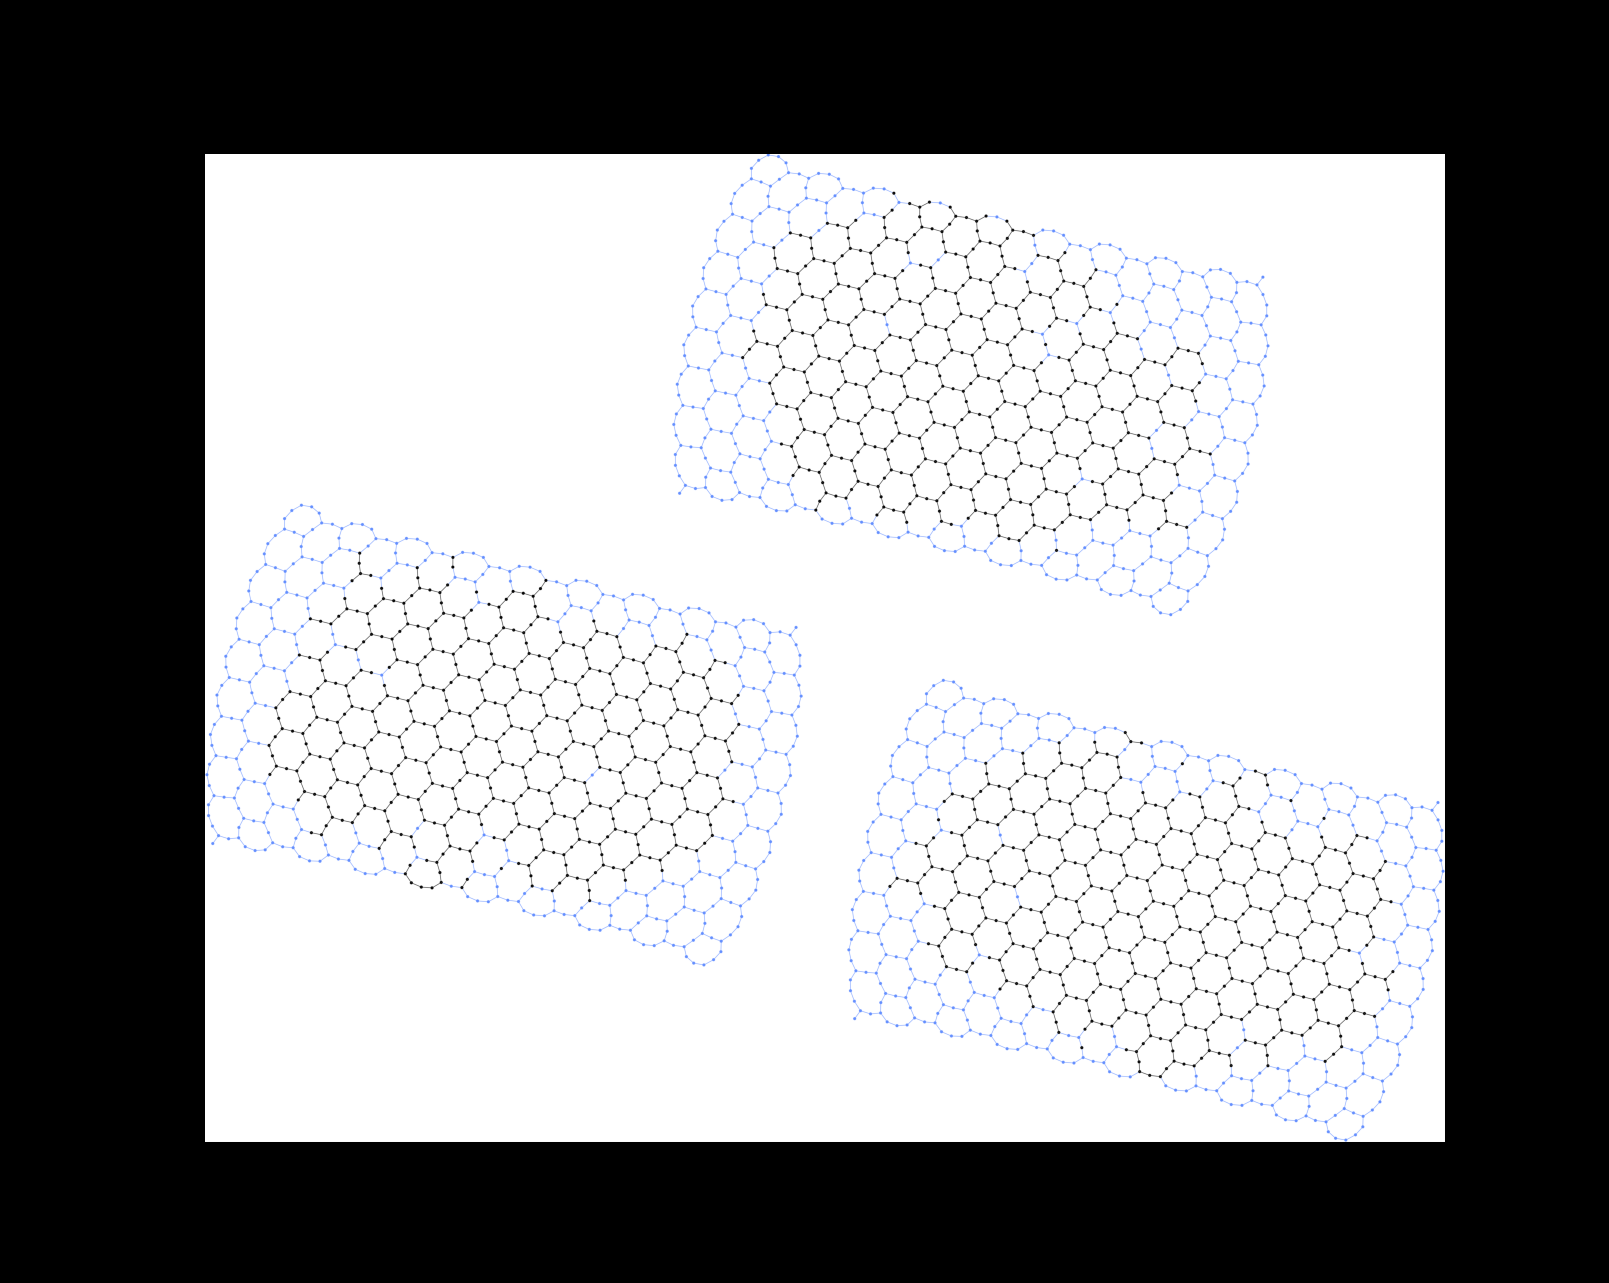

In [4]:
from qiskit.visualization import plot_circuit_layout
# Compile the split ghz circuit
tqc = transpile(ghz, backend)
# Visualize the selected layout
path = os.path.join(tempfile.gettempdir(), "locc_layout_map.png")

plot_circuit_layout(tqc, backend).savefig(path, dpi=10)
Image.open(path)

In [5]:
from qiskit.circuit import QuantumCircuit

num_qubits = 1500
bv = QuantumCircuit(num_qubits, num_qubits - 1)
bv.x(num_qubits - 1)
bv.h(range(num_qubits))
bv.cx(range(num_qubits - 1), num_qubits - 1)
bv.h(range(num_qubits))
bv.measure(range(num_qubits - 1), range(num_qubits - 1));

In [6]:
from qiskit.transpiler import TranspilerError
from qiskit import transpile

# Unable to compile a 1500 qubit connected circuit on the multichip backend
# because each chip is 883 qubits
try:
    transpile(bv, backend)
except TranspilerError as e:
    print(e)

'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map.'


### Build a backend to experiment with potential future hardware
This example builds a backend that is

In [7]:
class FakeTorusBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self):
        """Instantiate a new backend that is inspired by a toric code"""
        super().__init__(name='Fake LOCC backend')
        graph = rx.generators.directed_grid_graph(20, 20)
        for column in range(20):
            graph.add_edge(column, 19*20 + column, None)
        for row in range(20):
            graph.add_edge(row * 20, row * 20 + 19, None)
        num_qubits = len(graph)
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake Kookaburra", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for edge in graph.edge_list():
            offset = i * len(graph)
            cz_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
            )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

In [8]:
backend = FakeTorusBackend()

CZ gates: 781
X gates: 4
SX gates: 1436
RZ gates: 1269


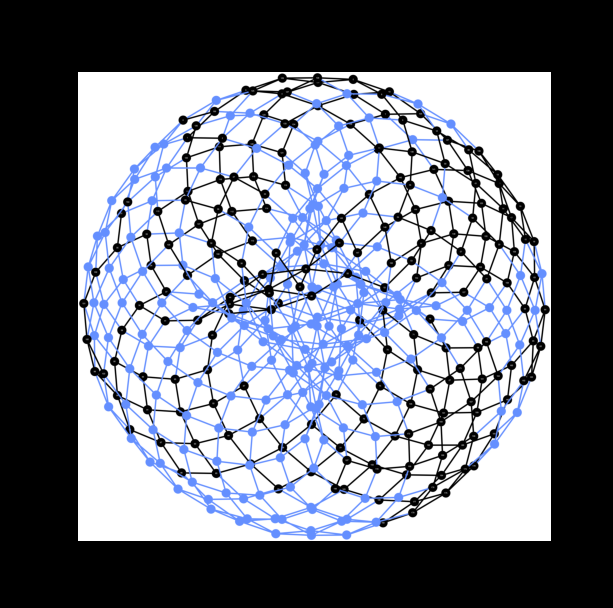

In [9]:
num_qubits = int(backend.num_qubits / 2)
full_device_bv = QuantumCircuit(num_qubits, num_qubits - 1)
full_device_bv.x(num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.cx(range(num_qubits - 1), num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.measure(range(num_qubits - 1), range(num_qubits - 1));
tqc = transpile(full_device_bv, backend, optimization_level=3)
op_counts = tqc.count_ops()
print(f"CZ gates: {op_counts['cz']}")
print(f"X gates: {op_counts['x']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

path = os.path.join(tempfile.gettempdir(), "torus_layout_map.png")
plot_circuit_layout(tqc, backend).savefig(path, dpi=30)
Image.open(path)